<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/market_quotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market quotes

In this notebook, I'll show a pitfall to avoid when multiple quotes need to be updated.

In [1]:
%matplotlib inline
import numpy as np
import utils

In [ ]:
!pip install QuantLib-Python

In [2]:
import QuantLib as ql

In [3]:
today = ql.Date(17, ql.October, 2016)
ql.Settings.instance().evaluationDate = today

#### Setting the stage

For illustration purposes, I'll create a bond curve using the same data and algorithm shown in one of the QuantLib C++ examples; namely, I'll give to the curve the functional form defined by the Nelson-Siegel model and I'll fit it to a number of bond.  Here are the maturities in years and the coupons of the bonds I'll use:

In [4]:
data = [ (2, 0.02),  (4, 0.0225),  (6, 0.025),  (8, 0.0275),
        (10, 0.03), (12, 0.0325), (14, 0.035), (16, 0.0375),
        (18, 0.04), (20, 0.0425), (22, 0.045), (24, 0.0475),
        (26, 0.05), (28, 0.0525), (30, 0.055)]

For simplicity, I'll use the same start date, frequency and conventions for all the bonds; this doesn't affect the point I'm going to make in the rest of the notebook. I'll also assume that all bonds currently price at 100.  I'll skip over the details of building the curve now; the one thing you'll need to remember is that it depends on the quotes modeling the bond prices.

In [5]:
calendar = ql.TARGET()
settlement = calendar.advance(today, 3, ql.Days)
quotes = []
helpers = []
for length, coupon in data:
    maturity = calendar.advance(settlement, length, ql.Years)
    schedule = ql.Schedule(
        settlement, maturity, ql.Period(ql.Annual),
        calendar, ql.ModifiedFollowing, ql.ModifiedFollowing,
        ql.DateGeneration.Backward, False)
    quote = ql.SimpleQuote(100.0)
    quotes.append(quote)
    helpers.append(
        ql.FixedRateBondHelper(ql.QuoteHandle(quote), 3, 100.0,
                               schedule, [coupon], ql.SimpleDayCounter(),
                               ql.ModifiedFollowing))

curve = ql.FittedBondDiscountCurve(0, calendar, helpers,
                                   ql.SimpleDayCounter(),
                                   ql.NelsonSiegelFitting())

Here is a visualization of the curve as discount factors versus time in years:

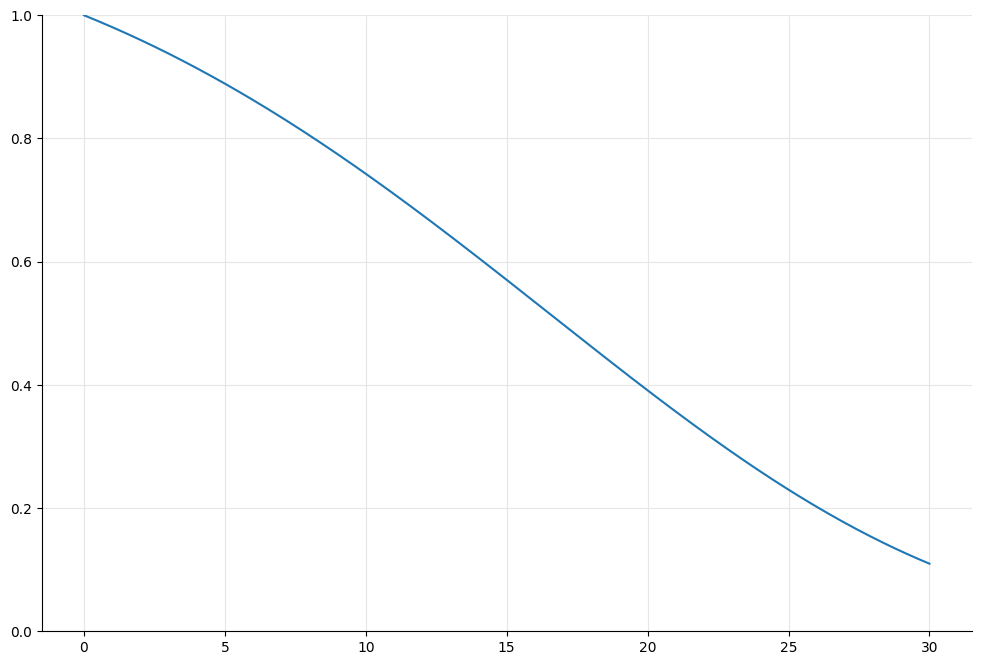

In [6]:
sample_times = np.linspace(0.0, 30.0, 301)
sample_discounts = [ curve.discount(t) for t in sample_times ]

f, ax = utils.plot()
ax.set_ylim(0.0, 1.0)
ax.plot(sample_times, sample_discounts);

Also, here's a bond priced by discounting its coupons on the curve:

In [7]:
schedule = ql.Schedule(today, calendar.advance(today, 15, ql.Years),
                       ql.Period(ql.Semiannual), calendar,
                       ql.ModifiedFollowing, ql.ModifiedFollowing,
                       ql.DateGeneration.Backward, False)
bond = ql.FixedRateBond(3, 100.0, schedule, [0.04], ql.Actual360())
bond.setPricingEngine(
    ql.DiscountingBondEngine(ql.YieldTermStructureHandle(curve)))
print(bond.cleanPrice())

105.77449622178025


#### "It looked like a good idea at the time"

Now, let's add an observer that checks whether the bond is out of date, and if so recalculates the bond and outputs its new price.  In Python, I can do this by defining a function to be triggered by the notifications, by passing it to the observer I'm creating, and (this last step is as in C++) by registering the observer with the bond.

As a reminder of how the whole thing works: the changes will come from the market quotes, but the observer doesn't need to be concerned with that and only registers with the object it's ultimately interested in; in this case, the bond whose price it wants to monitor.  A change in any of the market quotes will cause the quote to notify the helper, which in turn will notify the curve, and so on to the pricing engine, the bond and finally our observer.

In [8]:
prices = []
def print_price():
    p = bond.cleanPrice()
    prices.append(p)
    print(p)
o = ql.Observer(print_price)
o.registerWith(bond)

The function also appends the new price to a list that can be used later as a history of the prices. Let's see if it works:

In [9]:
quotes[2].setValue(101.0)

105.77449622178025
105.86560413454633


Whoa, what was that? The function was called twice, which surprised me too when I wrote this notebook.  It turns out that, due to a glitch of multiple inheritance, the curve sends two notifications to the instrument. After the first, the instrument recalculates but the curve doesn't (which explains why the price doesn't change); after the second, the curve updates and the price changes.  This should be fixed in a future release, but again it doesn't change the point of the notebook.

Let's set the quote back to its original value.

In [10]:
quotes[2].setValue(100.0)

105.86560413454633
105.77449632602422


Now, let's say the market moves up and, accordingly, all the bonds prices increase to 101.  Therefore, we need to update all the quotes.

In [11]:
prices = []
for q in quotes:
    q.setValue(101.0)

105.77449632602422
105.28388421801475
105.28388421801475
105.2186292238055
105.2186292238055
105.31959063332916
105.31959063332916
105.4878663261018
105.4878663261018
105.68032057288742
105.68032057288742
105.87580396665263
105.87580396665263
106.06201692071569
106.06201692071569
106.23044659597666
106.23044659597666
106.37409219514531
106.37409219514531
106.48708840535757
106.48708840535757
106.56505216839506
106.56505216839506
106.6057074004982
106.6057074004982
106.60980178159524
106.60980178159524
106.58011175261714
106.58011175261714
106.52070688437946


As you see, each of the updates sent a notification and thus triggered a recalculation.  We can use the list of prices we collected (slicing it to skip duplicate values) to visualize how the price changed.

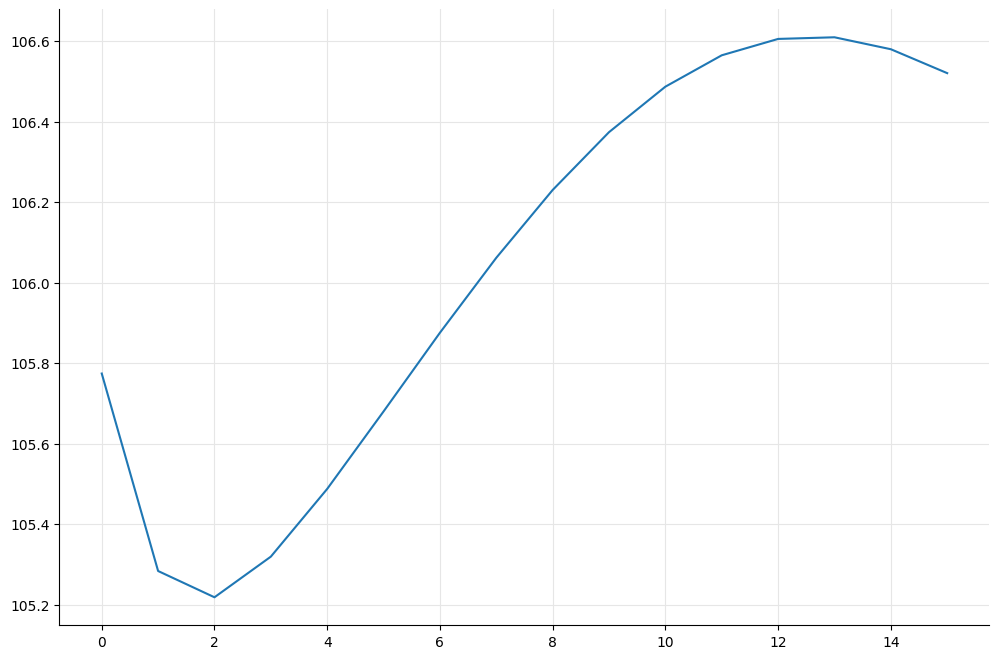

In [12]:
unique_prices = prices[::2]+prices[-1::]
_, ax = utils.plot()
ax.plot(unique_prices, '-');

The first price is the original one, and the last price is the final one; but all those in between are calculated based on an incomplete set of changes in which some quotes were updated and some others weren't.  Those are all incorrect, and (since they went both above and below the range of the real prices) outright dangerous in case there were any triggers on price levels that could have fired. Clearly, this is not the kind of behavior we want our code to have.

#### Alternatives?

There are workarounds we can apply. For instance, it's possible to freeze the bond temporarily, preventing it from forwarding notifications.

In [13]:
bond.freeze()

Now, notifications won't be forwarded by the bond and thus won't reach our observer. In fact, the following loop won't print anything.

In [14]:
for q in quotes:
    q.setValue(101.5)

When we restore the bond, it sends a single notification, which triggers only one recalculation and gives the correct final price.

In [15]:
bond.unfreeze()

106.85839332472605


When using C++, it's also possible to disable and re-enable notifications globally, which makes it more convenient.

But it all feels a bit convoluted anyway. The whole thing will be simpler if we discard the initial idea and don't force a recalculation for each notification.

#### Pull, don't push

It's preferable for updates to _not_ trigger recalculation and just set some kind of dirty flag, just like the instruments in the library do.  This way, you can control when the calculation occur.

To do so, let's remove the observer we have in place...

In [16]:
del o

...and instead create one that raises a flag when it's notified.

In [17]:
flag = {}
flag['status'] = 'down'
def set_flag():
    flag['status'] = 'up'
o = ql.Observer(set_flag)
o.registerWith(bond)

The flag is initially down...

In [18]:
print(flag)

{'status': 'down'}


...and quote changes cause it to be raised.

In [19]:
for q in quotes:
    q.setValue(100.0)

In [20]:
print(flag)

{'status': 'up'}


At this point, we can ask the bond for its final price.

In [21]:
bond.cleanPrice()

105.77449633968729

Better yet, we can let the instrument do that: let's remove the second observer, too, and just ask the instrument for its price after the changes.  The instrument keeps track of whether it needs recalculation, so it doesn't need us to keep track of it.

In [22]:
del o

In [23]:
for q in quotes:
    q.setValue(101.0)

In [24]:
bond.cleanPrice()

106.52070679688055

So, less is more? In this case, it seems so.